In [1]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 3

import xarray as xr
import matplotlib.pyplot as plt
from helpers.computational_tools import *
import xesmf as xe
import xgcm

from helpers.collection_of_experiments import CollectionOfExperiments

In [2]:
lores_NW2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/snapshots*.nc', decode_times=False).sel(time=slice(29000,30000))

In [3]:
lores_longmean = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_*.nc', decode_times=False).sel(time=slice(29000,30000))

In [4]:
ann_longmean = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-Coriolis/output/longmean_*.nc', decode_times=False).sel(time=slice(29000,30000))

In [5]:
ann_NW2 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/May22-Coriolis/output/snapshots*.nc', decode_times=False).sel(time=slice(29000,30000))

In [ ]:
ref = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_*', decode_times=False).isel(time=slice(None,None,6))[['u','v','h','e']]
%time ref = ref.coarsen({'xq':8, 'xh':8, 'yq': 8, 'yh':8}, boundary='pad').mean().compute()

In [6]:
ref = ref.interp(yq = ann_NW2.yq, xq = ann_NW2.xq)

In [6]:
#ref.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/coarsened_snapshots.nc')
ref = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/coarsened_snapshots.nc', decode_times=False)

In [7]:
ref_longmean = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean_*', decode_times=False)

In [8]:
ref_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False).squeeze().drop_vars('time')

In [9]:
out = - (ref_longmean.uh / 1e+6).mean('time').sum('zl').cumsum('yh').compute()
psi_ref = out - out.sel(xq=0, yh=0, method='nearest')

In [10]:
R4_longmean = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-uploaded/longmean_*', decode_times=False)

In [11]:
out = - (R4_longmean.uh / 1e+6).mean('time').sum('zl').cumsum('yh').compute()
psi_R4 = out - out.sel(xq=0, yh=0, method='nearest')

In [12]:
lores_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/static.nc', decode_times=False)

In [13]:
grid = xgcm.Grid(lores_NW2.isel(time=0).drop_vars('time').squeeze(), coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'}
    },
    boundary={"X": 'periodic', 'Y': 'fill'},
    fill_value = {'Y':0})

In [14]:
grid_ref = xgcm.Grid(ref_static, coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'}
    },
    boundary={"X": 'periodic', 'Y': 'fill'},
    fill_value = {'Y':0})

In [15]:
def APE(interface):
    '''
    Returns APE in units of kinetic energy per unit mass, i.e.
    m^3/s^2
    '''
    interface_rest = xr.DataArray([    0.,   -25.,   -75.,  -175.,  -300.,  -450.,  -625.,  -825.,
       -1050., -1300., -1600., -1950., -2350., -2850., -3400., -4000.], dims='zi')
    g = xr.DataArray([1.0e+01, 2.1e-03, 3.9e-03, 5.4e-03, 5.8e-03, 5.8e-03, 5.7e-03,
       5.3e-03, 4.8e-03, 4.2e-03, 3.7e-03, 3.1e-03, 2.4e-03, 1.7e-03,
       1.1e-03, 0.0e+00], dims='zi')
    
    coordinate_of_bottom = interface.isel(zi=-1).drop_vars(['zi'])
    
    hint = interface - interface_rest
    
    # Where bottom is upper than the rest interface
    hbot = np.maximum(coordinate_of_bottom - interface_rest,0)
    
    APE_instant = (0.5 * g * (hint**2))
    APE_constant = (0.5 * g * (hbot**2))
    
    return (APE_instant - APE_constant).sum('zi')

In [9]:
(APE(lores_NW2.e).isel(time=0) * lores_static.area_t).sum(['xh','yh']).compute()

<xarray.DataArray ()> Size: 8B
array(1.03995038e+17)
Coordinates:
    time     float64 8B 2.901e+04

In [16]:
def energy(data):
    data = data.chunk({'zl':1})
    h = (data.e.isel(zi=slice(0,-1)).drop_vars('zi') - data.e.isel(zi=slice(1,None)).drop_vars('zi')).rename({'zi': 'zl'})
    out = xr.Dataset()

    KEu = (data.u**2 * grid.interp(h,'X') * 0.5).chunk({'yh':100}).mean('time').compute()
    KEv = (data.v**2 * grid.interp(h,'Y') * 0.5).chunk({'xh':100}).mean('time').compute()
    
    out['KE'] = (grid.interp(KEu,'X') + grid.interp(KEv,'Y')).sum('zl')

    uom = data.u.chunk({'yh':100}).mean('time').compute()
    vom = data.v.chunk({'yq':100}).mean('time').compute()
    hm = h.chunk({'yh':100}).mean('time').compute()

    KEu = (uom**2 * grid.interp(hm,'X') * 0.5)
    KEv = (vom**2 * grid.interp(hm,'Y') * 0.5)

    out['MKE'] = (grid.interp(KEu,'X') + grid.interp(KEv,'Y')).sum('zl')

    out['EKE'] = out['KE'] - out['MKE']

    out['APE'] = APE(data.e).mean('time').compute()
    out['MPE'] = APE(data.e.mean('time')).compute()
    out['EPE'] = out['APE'] - out['MPE']
    

    return out

In [17]:
def psi(data, static):
    out = - (static.dyCu * data.u * grid.interp(data.h, 'X') / 1e+6).mean('time').sum('zl').cumsum('yh').compute()
    out = out - out.sel(xq=0, yh=0, method='nearest')
    return out

In [18]:
psi_lores = psi(lores_NW2, lores_static)
psi_ann = psi(ann_NW2, lores_static)

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [19]:
%%time
energy_ctrl = energy(lores_NW2)

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent 

CPU times: user 8.17 s, sys: 5.84 s, total: 14 s
Wall time: 12.7 s


In [20]:
energy_ann = energy(ann_NW2)

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent 

In [21]:
energy_ref = energy(ref)

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent 

In [22]:
import matplotlib as mpl
def plot(field, factor=1, label='KE', vmin=1e-1, vmax=1e+3, norm='linear', cmap=cmocean.cm.balance):
    if norm=='linear':
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    elif norm=='symlog':
        norm = mpl.colors.SymLogNorm(linthresh=vmin, linscale=0.1, vmin=-vmax, vmax=vmax)
    elif norm=='log':
        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    im = field.coarsen({'xh': factor, 'yh': factor}).mean().plot.imshow(
        norm=norm,
        cmap=cmap,
        add_colorbar=False,
        interpolation='none'
    )
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(label, fontsize=10)
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}^'+'{\circ}$E' for lon in lons])
    lats = [-60, -40, -20, 0, 20, 40, 60]
    lat_ticks = [f'${-lat}^'+'{\circ}$S' if lat<0 else f'${lat}^'+'{\circ}$N' for lat in lats]
    plt.yticks(lats, lat_ticks)    
    plt.colorbar(im, shrink=0.75, orientation='vertical', ax=plt.gca(), extend='both').set_label(fontsize=13, label=f'Depth-integrated {label}\n'+ '$\\mathrm{m}^3 \\mathrm{s}^{-2}$')

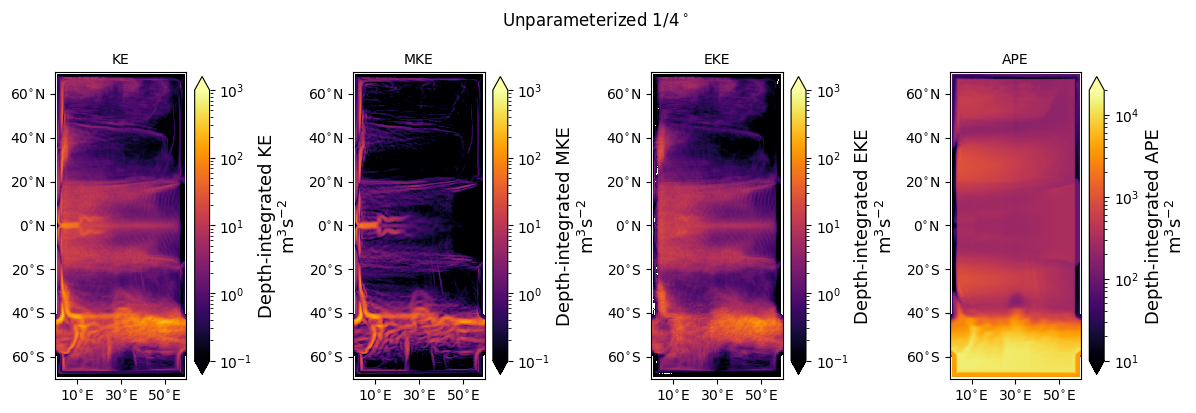

In [122]:
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)
plot(energy_ctrl.KE, vmin=1e-1, vmax=1e+3, label='KE', norm='log', cmap='inferno')
plt.subplot(1,4,2)
plot(energy_ctrl.MKE, vmin=1e-1, vmax=1e+3, label='MKE', norm='log', cmap='inferno')
plt.subplot(1,4,3)
plot(energy_ctrl.EKE, vmin=1e-1, vmax=1e+3, label='EKE', norm='log', cmap='inferno')
plt.subplot(1,4,4)
plot(energy_ctrl.APE, vmin=1e+1, vmax=2e+4, label='APE', norm='log', cmap='inferno')

plt.suptitle('Unparameterized $1/4^\circ$', y=0.9)
plt.tight_layout()

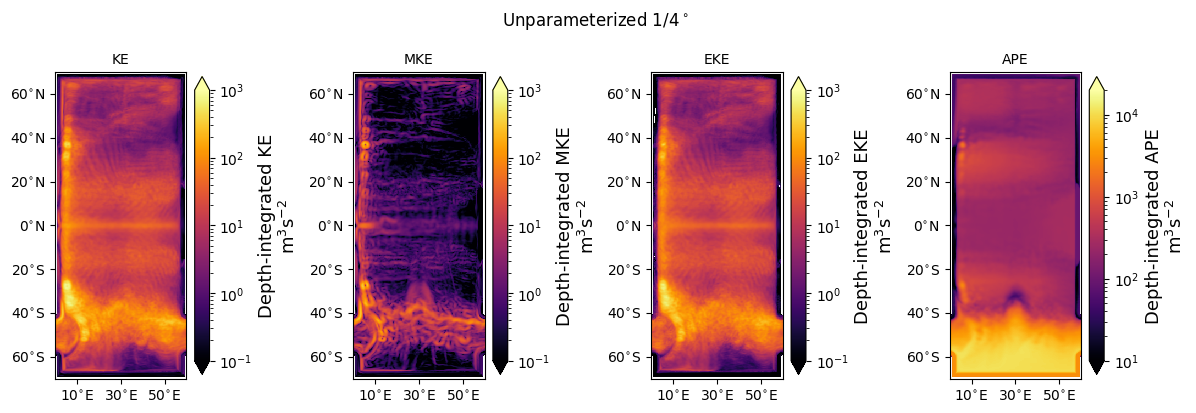

In [123]:
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)
plot(energy_ann.KE, vmin=1e-1, vmax=1e+3, label='KE', norm='log', cmap='inferno')
plt.subplot(1,4,2)
plot(energy_ann.MKE, vmin=1e-1, vmax=1e+3, label='MKE', norm='log', cmap='inferno')
plt.subplot(1,4,3)
plot(energy_ann.EKE, vmin=1e-1, vmax=1e+3, label='EKE', norm='log', cmap='inferno')
plt.subplot(1,4,4)
plot(energy_ann.APE, vmin=1e+1, vmax=2e+4, label='APE', norm='log', cmap='inferno')

plt.suptitle('Unparameterized $1/4^\circ$', y=0.9)
plt.tight_layout()

In [127]:
psi_r = psi_ref.coarsen({'xq':8, 'yh':8}, boundary='pad').mean().compute().interp(xq=psi_lores.xq)

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


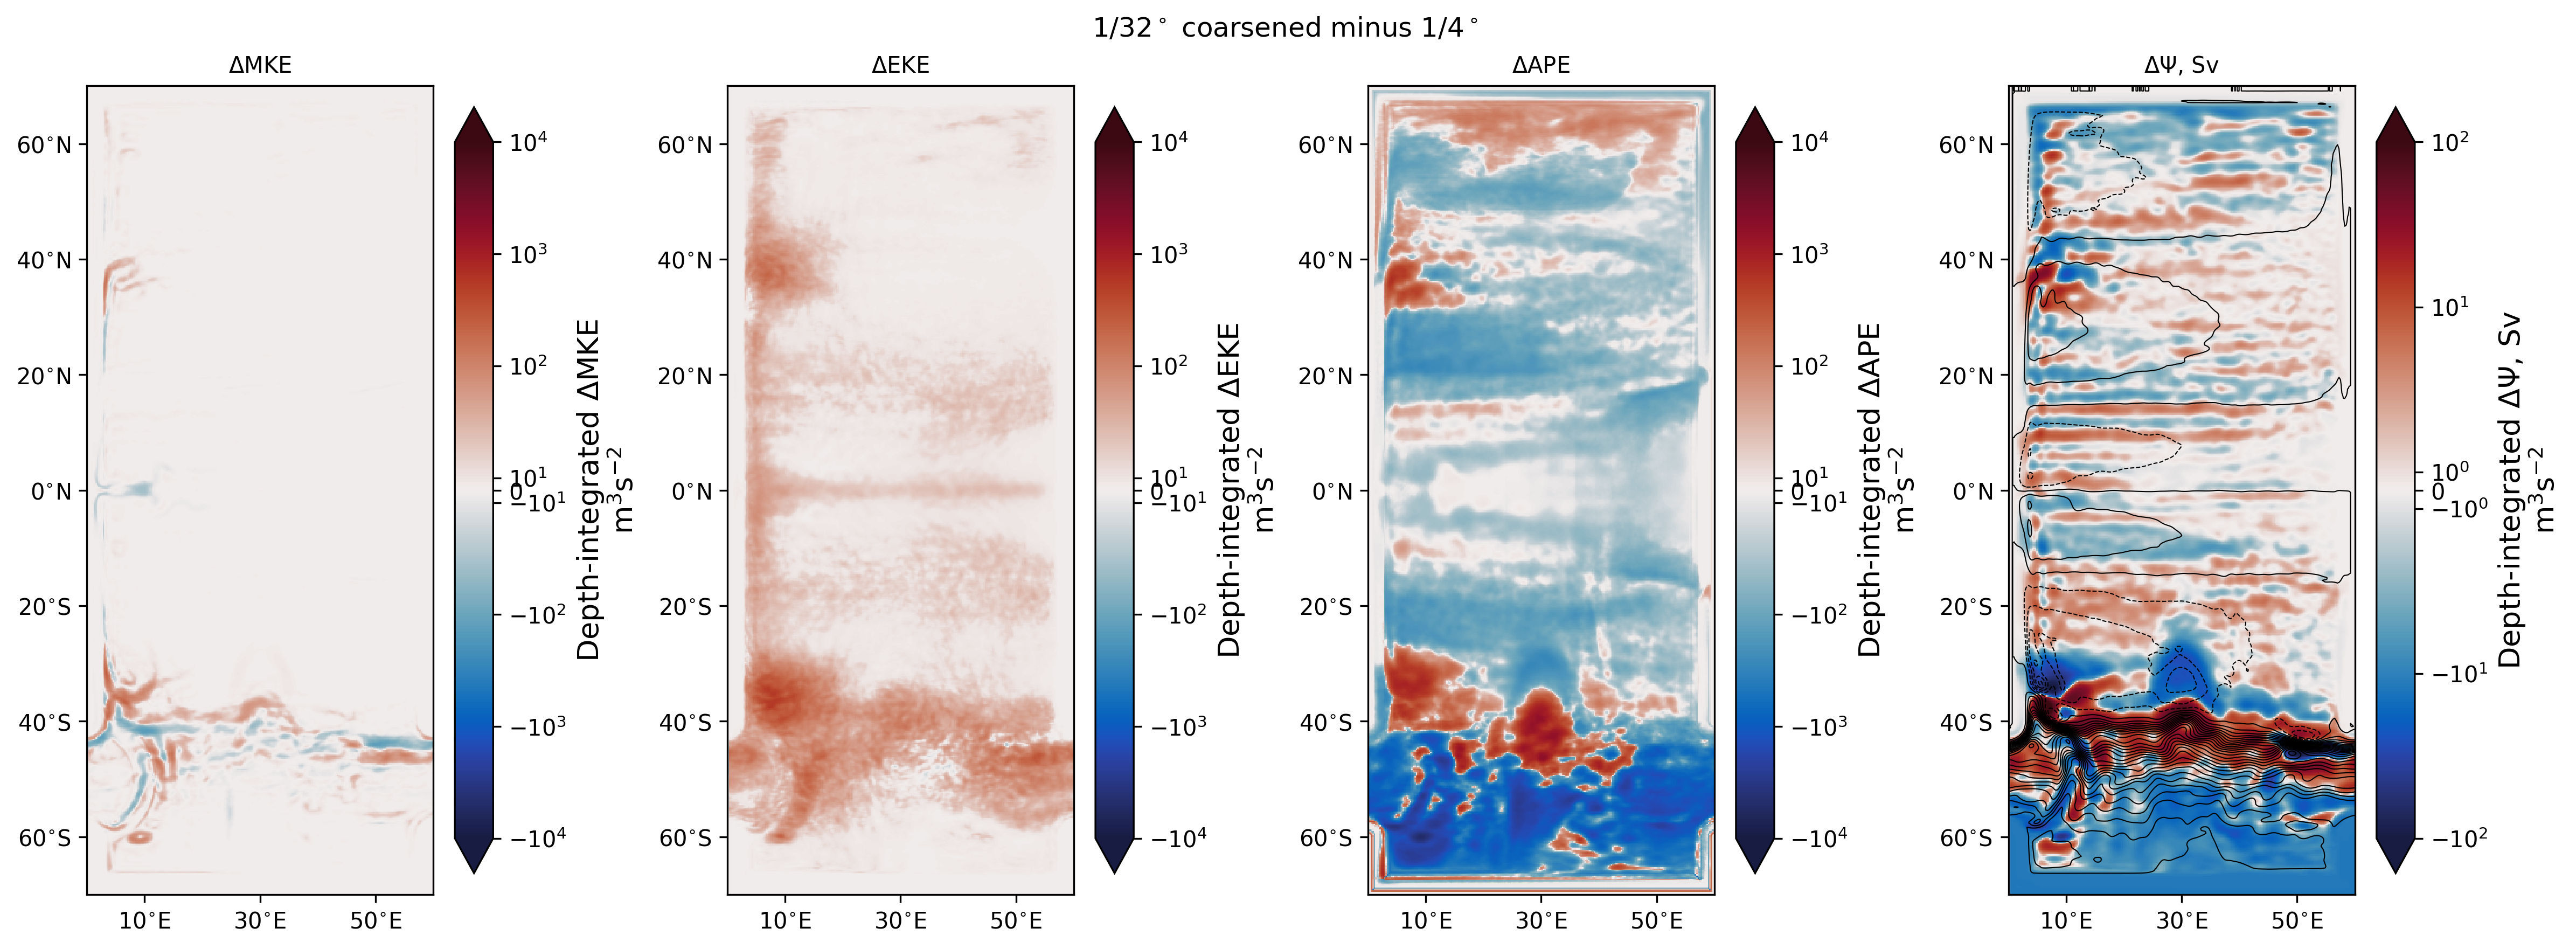

In [128]:
plt.figure(figsize=(16,7), dpi=300)
plt.subplot(1,4,2)
plot(energy_ref.EKE - energy_ctrl.EKE, vmin=1e+1, vmax=1e+4, label='$\Delta$EKE', norm='symlog', factor=1)
plt.subplot(1,4,1)
plot(energy_ref.MKE - energy_ctrl.MKE, vmin=1e+1, vmax=1e+4, label='$\Delta$MKE', norm='symlog', factor=1)
plt.subplot(1,4,3)
plot(energy_ref.APE - energy_ctrl.APE, vmin=1e+1, vmax=1e+4, label='$\Delta$APE', norm='symlog', factor=1)
plt.subplot(1,4,4)
psi_R4.plot.contour(levels=np.arange(-300,300,10), colors='k', linewidths=0.5)
plot(grid.interp(psi_r - psi_R4, 'X'), vmin=1, vmax=100, label='$\Delta\Psi$, Sv', norm='symlog', factor=1)


plt.suptitle('$1/32^\circ$ coarsened minus $1/4^\circ$', y=0.9)
plt.tight_layout()

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


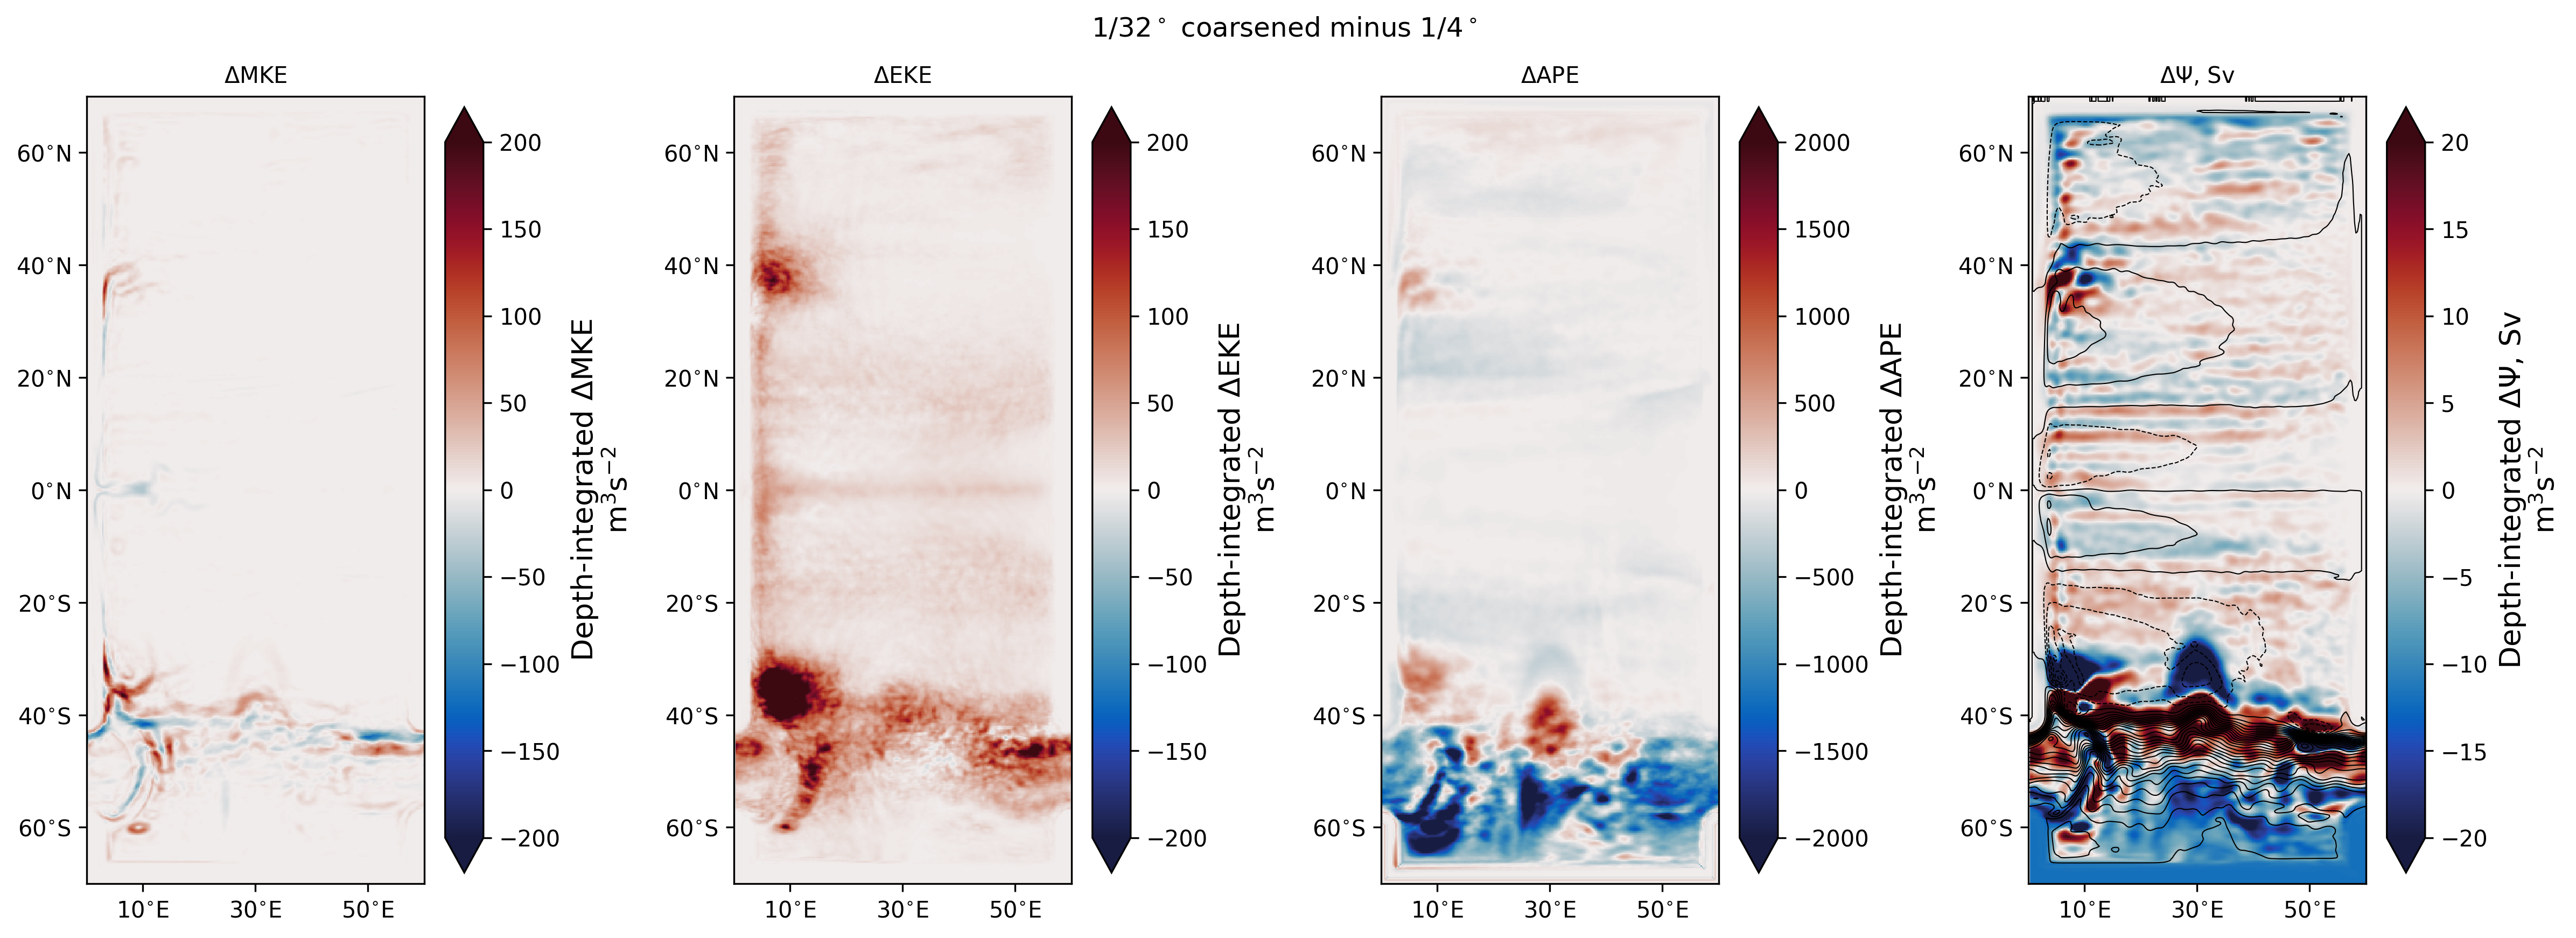

In [147]:
plt.figure(figsize=(16,7), dpi=300)
plt.subplot(1,4,2)
plot(energy_ref.EKE - energy_ctrl.EKE, vmin=-200, vmax=200, label='$\Delta$EKE', norm='linear', factor=1)
plt.subplot(1,4,1)
plot(energy_ref.MKE - energy_ctrl.MKE, vmin=-200, vmax=200, label='$\Delta$MKE', norm='linear', factor=1)
plt.subplot(1,4,3)
plot(energy_ref.APE - energy_ctrl.APE, vmin=-2000, vmax=2000, label='$\Delta$APE', norm='linear', factor=1)
plt.subplot(1,4,4)
psi_R4.plot.contour(levels=np.arange(-300,300,10), colors='k', linewidths=0.5)
plot(grid.interp(psi_r - psi_R4, 'X'), vmin=-20, vmax=20, label='$\Delta\Psi$, Sv', norm='linear', factor=1)


plt.suptitle('$1/32^\circ$ coarsened minus $1/4^\circ$', y=0.9)
plt.tight_layout()

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


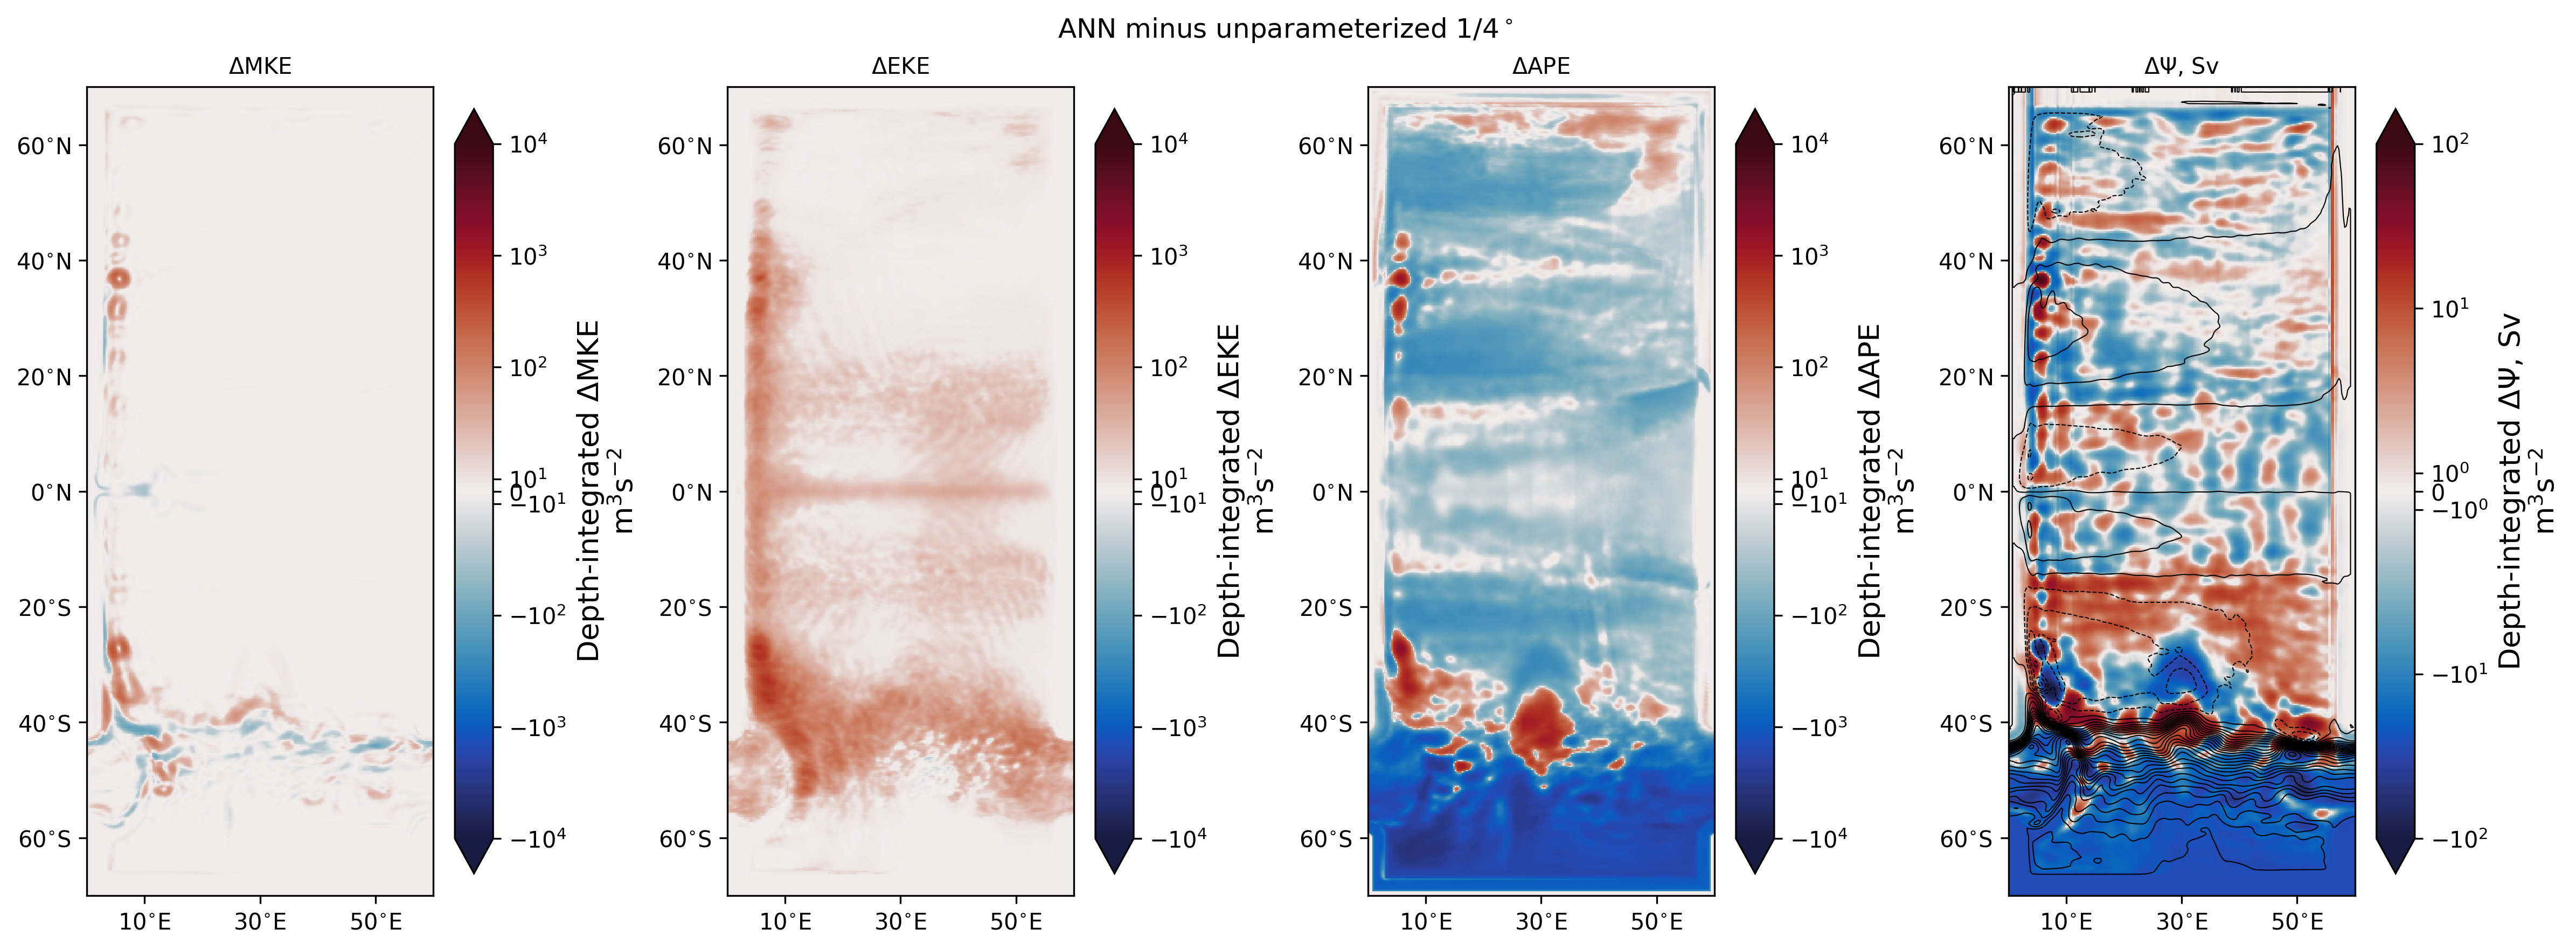

In [149]:
plt.figure(figsize=(16,7), dpi=300)
plt.subplot(1,4,2)
plot(energy_ann.EKE - energy_ctrl.EKE, vmin=1e+1, vmax=1e+4, label='$\Delta$EKE', norm='symlog', factor=1)
plt.subplot(1,4,1)
plot(energy_ann.MKE - energy_ctrl.MKE, vmin=1e+1, vmax=1e+4, label='$\Delta$MKE', norm='symlog', factor=1)
plt.subplot(1,4,3)
plot(energy_ann.APE - energy_ctrl.APE, vmin=1e+1, vmax=1e+4, label='$\Delta$APE', norm='symlog', factor=1)
plt.subplot(1,4,4)
psi_R4.plot.contour(levels=np.arange(-300,300,10), colors='k', linewidths=0.5)
plot(grid.interp(psi_ann - psi_lores, 'X'), vmin=1, vmax=100, label='$\Delta\Psi$, Sv', norm='symlog', factor=1)


plt.suptitle('ANN minus unparameterized $1/4^\circ$', y=0.9)
plt.tight_layout()

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


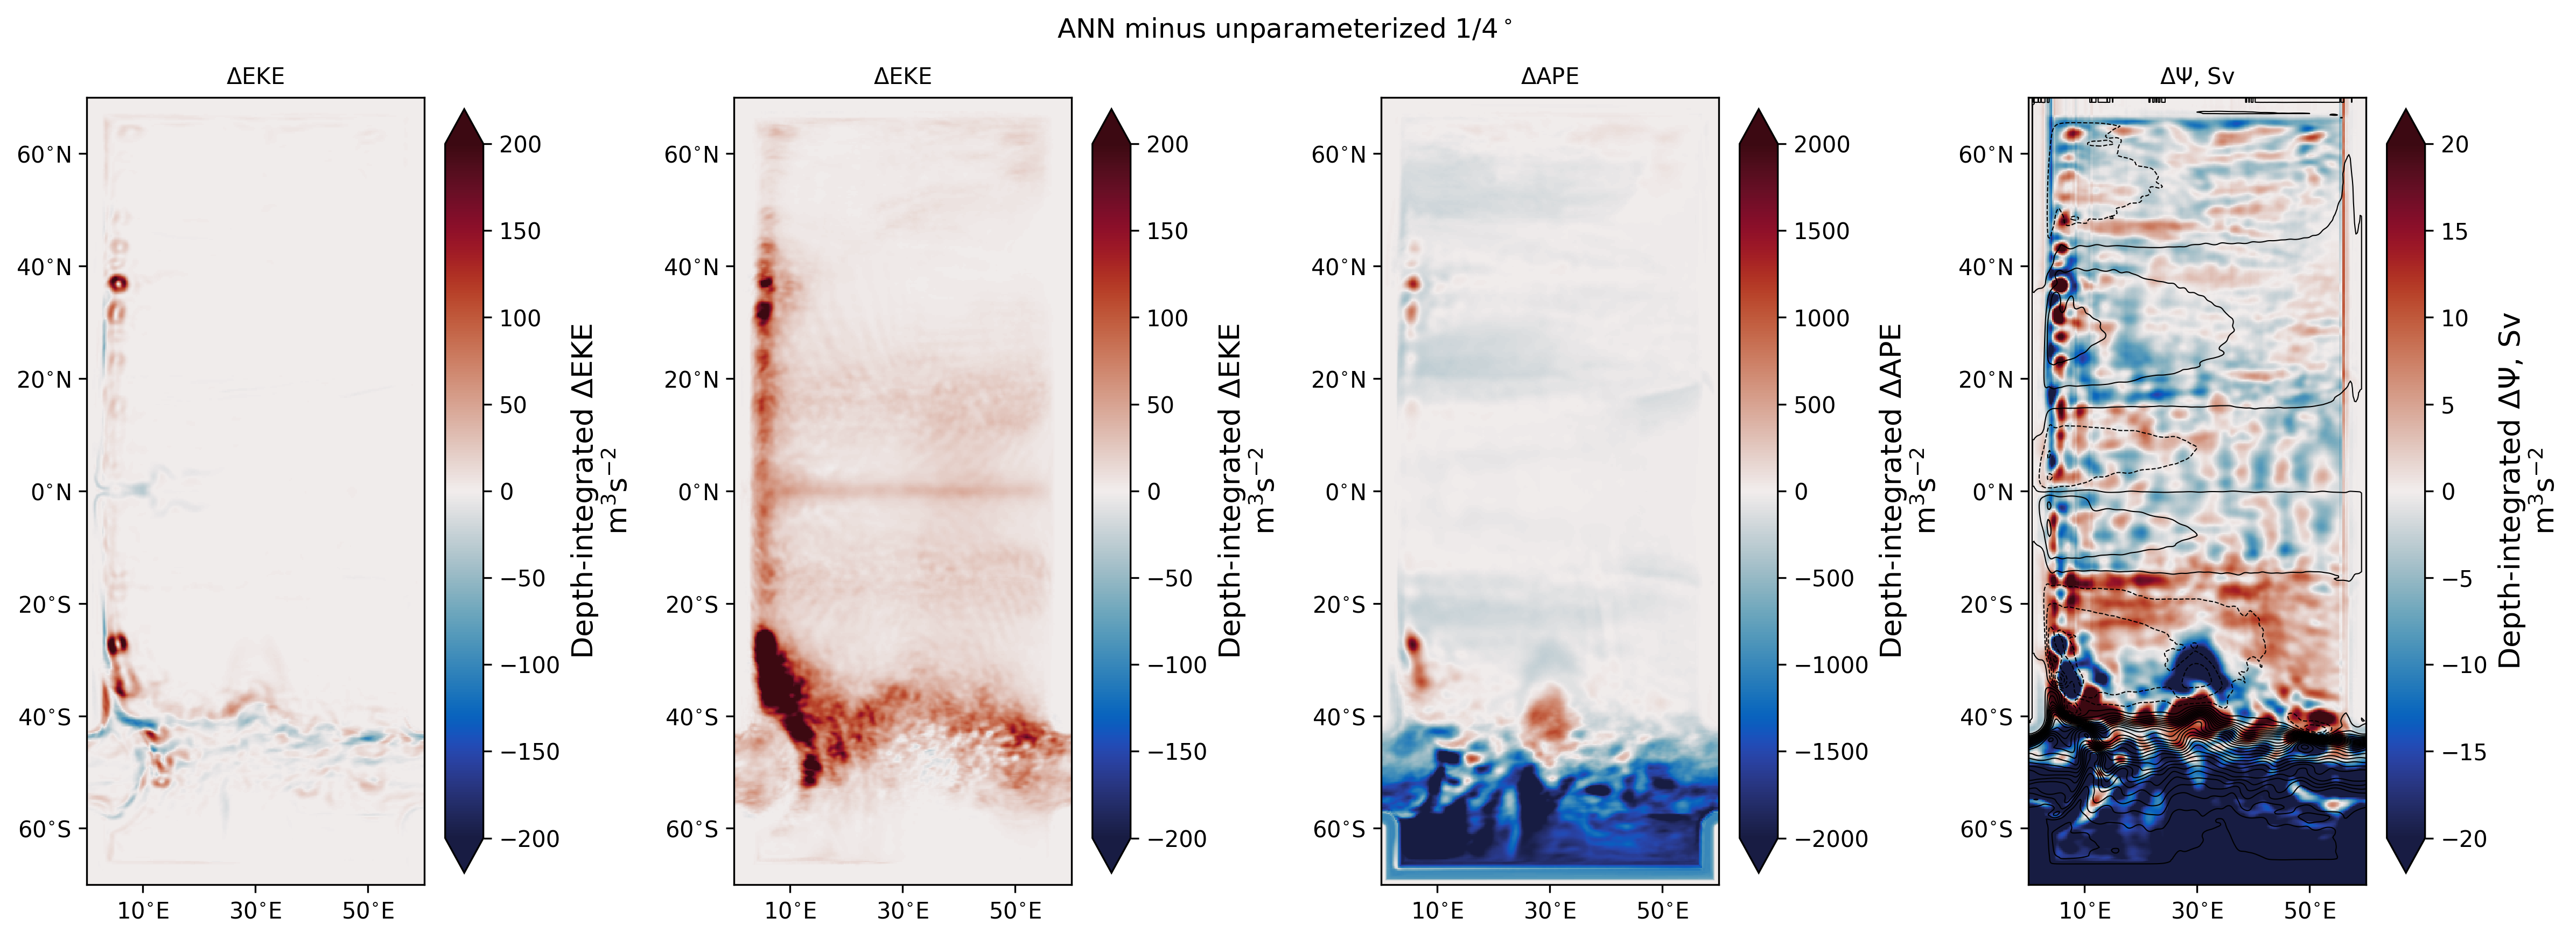

In [148]:
plt.figure(figsize=(16,7), dpi=300)
plt.subplot(1,4,2)
plot(energy_ann.EKE - energy_ctrl.EKE, vmin=-200, vmax=200, label='$\Delta$EKE', norm='linear', factor=1)
plt.subplot(1,4,1)
plot(energy_ann.MKE - energy_ctrl.MKE, vmin=-200, vmax=200, label='$\Delta$EKE', norm='linear', factor=1)
plt.subplot(1,4,3)
plot(energy_ann.APE - energy_ctrl.APE, vmin=-2000, vmax=2000, label='$\Delta$APE', norm='linear', factor=1)
plt.subplot(1,4,4)
psi_R4.plot.contour(levels=np.arange(-300,300,10), colors='k', linewidths=0.5)
plot(grid.interp(psi_ann - psi_lores, 'X'), vmin=-20, vmax=20, label='$\Delta\Psi$, Sv', norm='linear', factor=1)


plt.suptitle('ANN minus unparameterized $1/4^\circ$', y=0.9)
plt.tight_layout()

# Non-locality of APE extraction
Following GEOMETRIC ideas (Mak 2018), APE extraction is given by:
$$
\varepsilon = \int \kappa \frac{M^4}{N^2} dz
$$
where
$$
\kappa = \alpha E \frac{N}{M^2}, N^2 = \partial_z b, M^2 = |\nabla b|
$$

Substituting:
$$
\varepsilon = \int \alpha E \frac{M^2}{N} dz
$$
Introducing the definition of isopycnal slope:
$$
s =  |\nabla b| / \partial_z b = \frac{M^2}{N^2}
$$

So, the APE extraction:
$$
\varepsilon = \int \alpha E N s dz
$$

In [16]:
# This is reduced gravity g * (rho1-rho2)/rho0 on internal interfaces
g_prime = np.array([0.00209999999999923, 0.003900000000001, 0.00539999999999964, 
    0.00579999999999927, 0.00580000000000155, 0.00569999999999936, 
    0.00529999999999973, 0.00480000000000018, 0.00420000000000073, 
    0.00369999999999891, 0.00309999999999945, 0.00240000000000009, 
    0.00170000000000073, 0.001099999999999])
# For convenience we will interpolate this data to layers
g_prime_zl = xr.DataArray(np.zeros(15), dims='zl')
g_prime_zl[0] = g_prime[0]
g_prime_zl[-1] = g_prime[-1]
g_prime_zl[1:-1] = 0.5 * (g_prime[0:-1] + g_prime[1:None])
g_prime_zl

<xarray.DataArray (zl: 15)> Size: 120B
array([0.0021 , 0.003  , 0.00465, 0.0056 , 0.0058 , 0.00575, 0.0055 ,
       0.00505, 0.0045 , 0.00395, 0.0034 , 0.00275, 0.00205, 0.0014 ,
       0.0011 ])
Dimensions without coordinates: zl

In [146]:
# Compute buoyancy frequency only where thickness is larger than 1 meter
h = ref.h.mean('time').compute()
N = xr.where(h>1, np.sqrt(g_prime_zl / h), np.nan)

In [106]:
# Compute slope only where interface is at least one meter above the depth
slopex = grid.interp(grid.diff(ref.e.mean('time'), 'X') / lores_static.dxCu,'X')
slopey = grid.interp(grid.diff(ref.e.mean('time'), 'Y') / lores_static.dyCv,'Y')
slope = xr.where(ref.e.mean('time')>ref.e.mean('time').isel(zi=-1)+1, np.sqrt(slopex**2 + slopey**2), np.nan)
slope_zl = xr.zeros_like(N) +  (slope[0:15].values + slope[1:16].values) * 0.5

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent 

In [128]:
def ave_z(x):
    return (x * h).sum('zl') / h.sum('zl')

In [132]:
def sum_z(x):
    return (x * h).sum('zl')

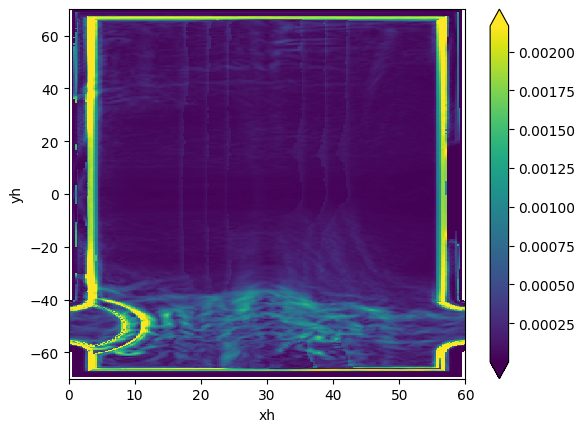

In [130]:
ave_z(slope_zl).plot(robust=True)

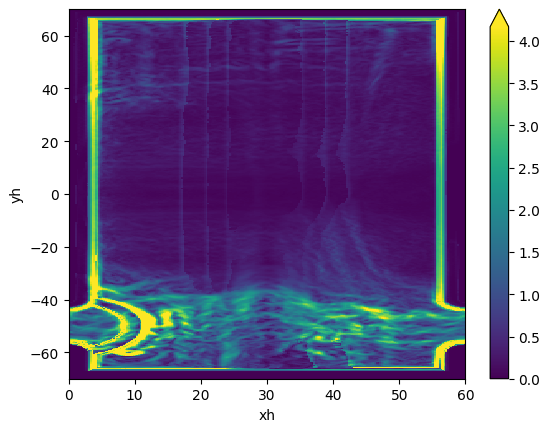

In [131]:
sum_z(slope_zl).plot(robust=True)

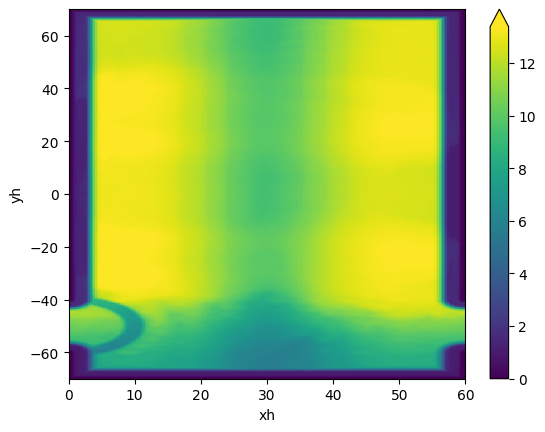

In [133]:
sum_z(N).plot(robust=True)

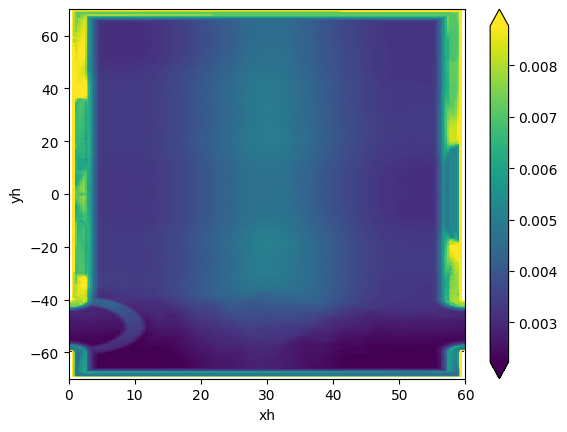

In [134]:
ave_z(N).plot(robust=True)

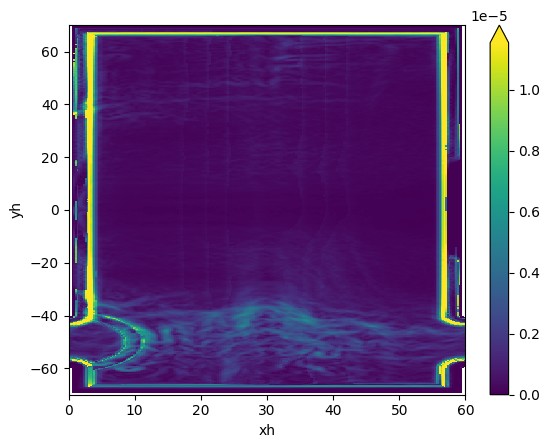

In [138]:
ave_z(N*slope_zl).plot(robust=True)

In [147]:
APE_extraction = ave_z(energy_ref.EKE * N * slope_zl)
dAPE_extraction = ave_z((energy_ref.EKE - energy_ctrl.EKE)  * N * slope_zl)

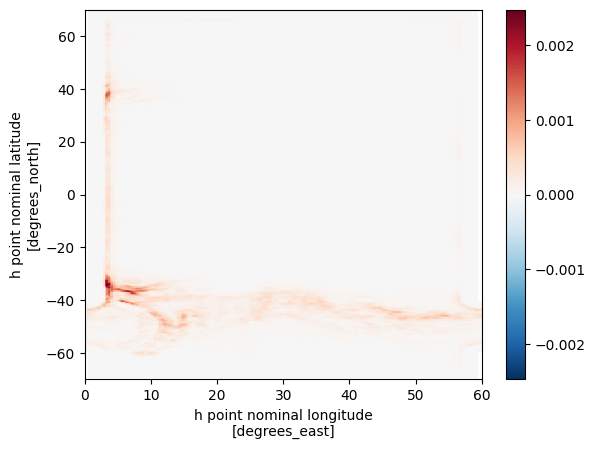

In [148]:
APE_extraction.plot()

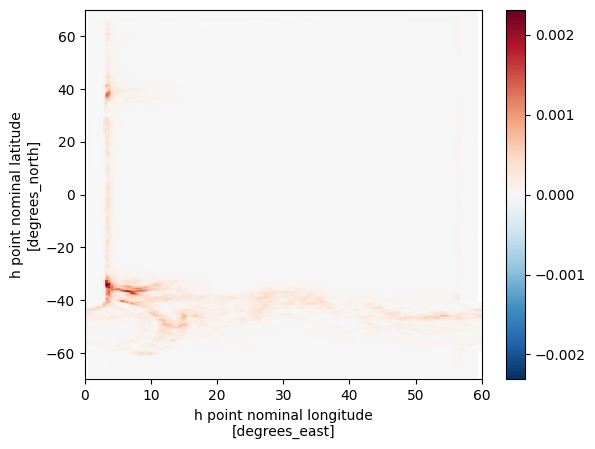

In [156]:
dAPE_extraction.plot()

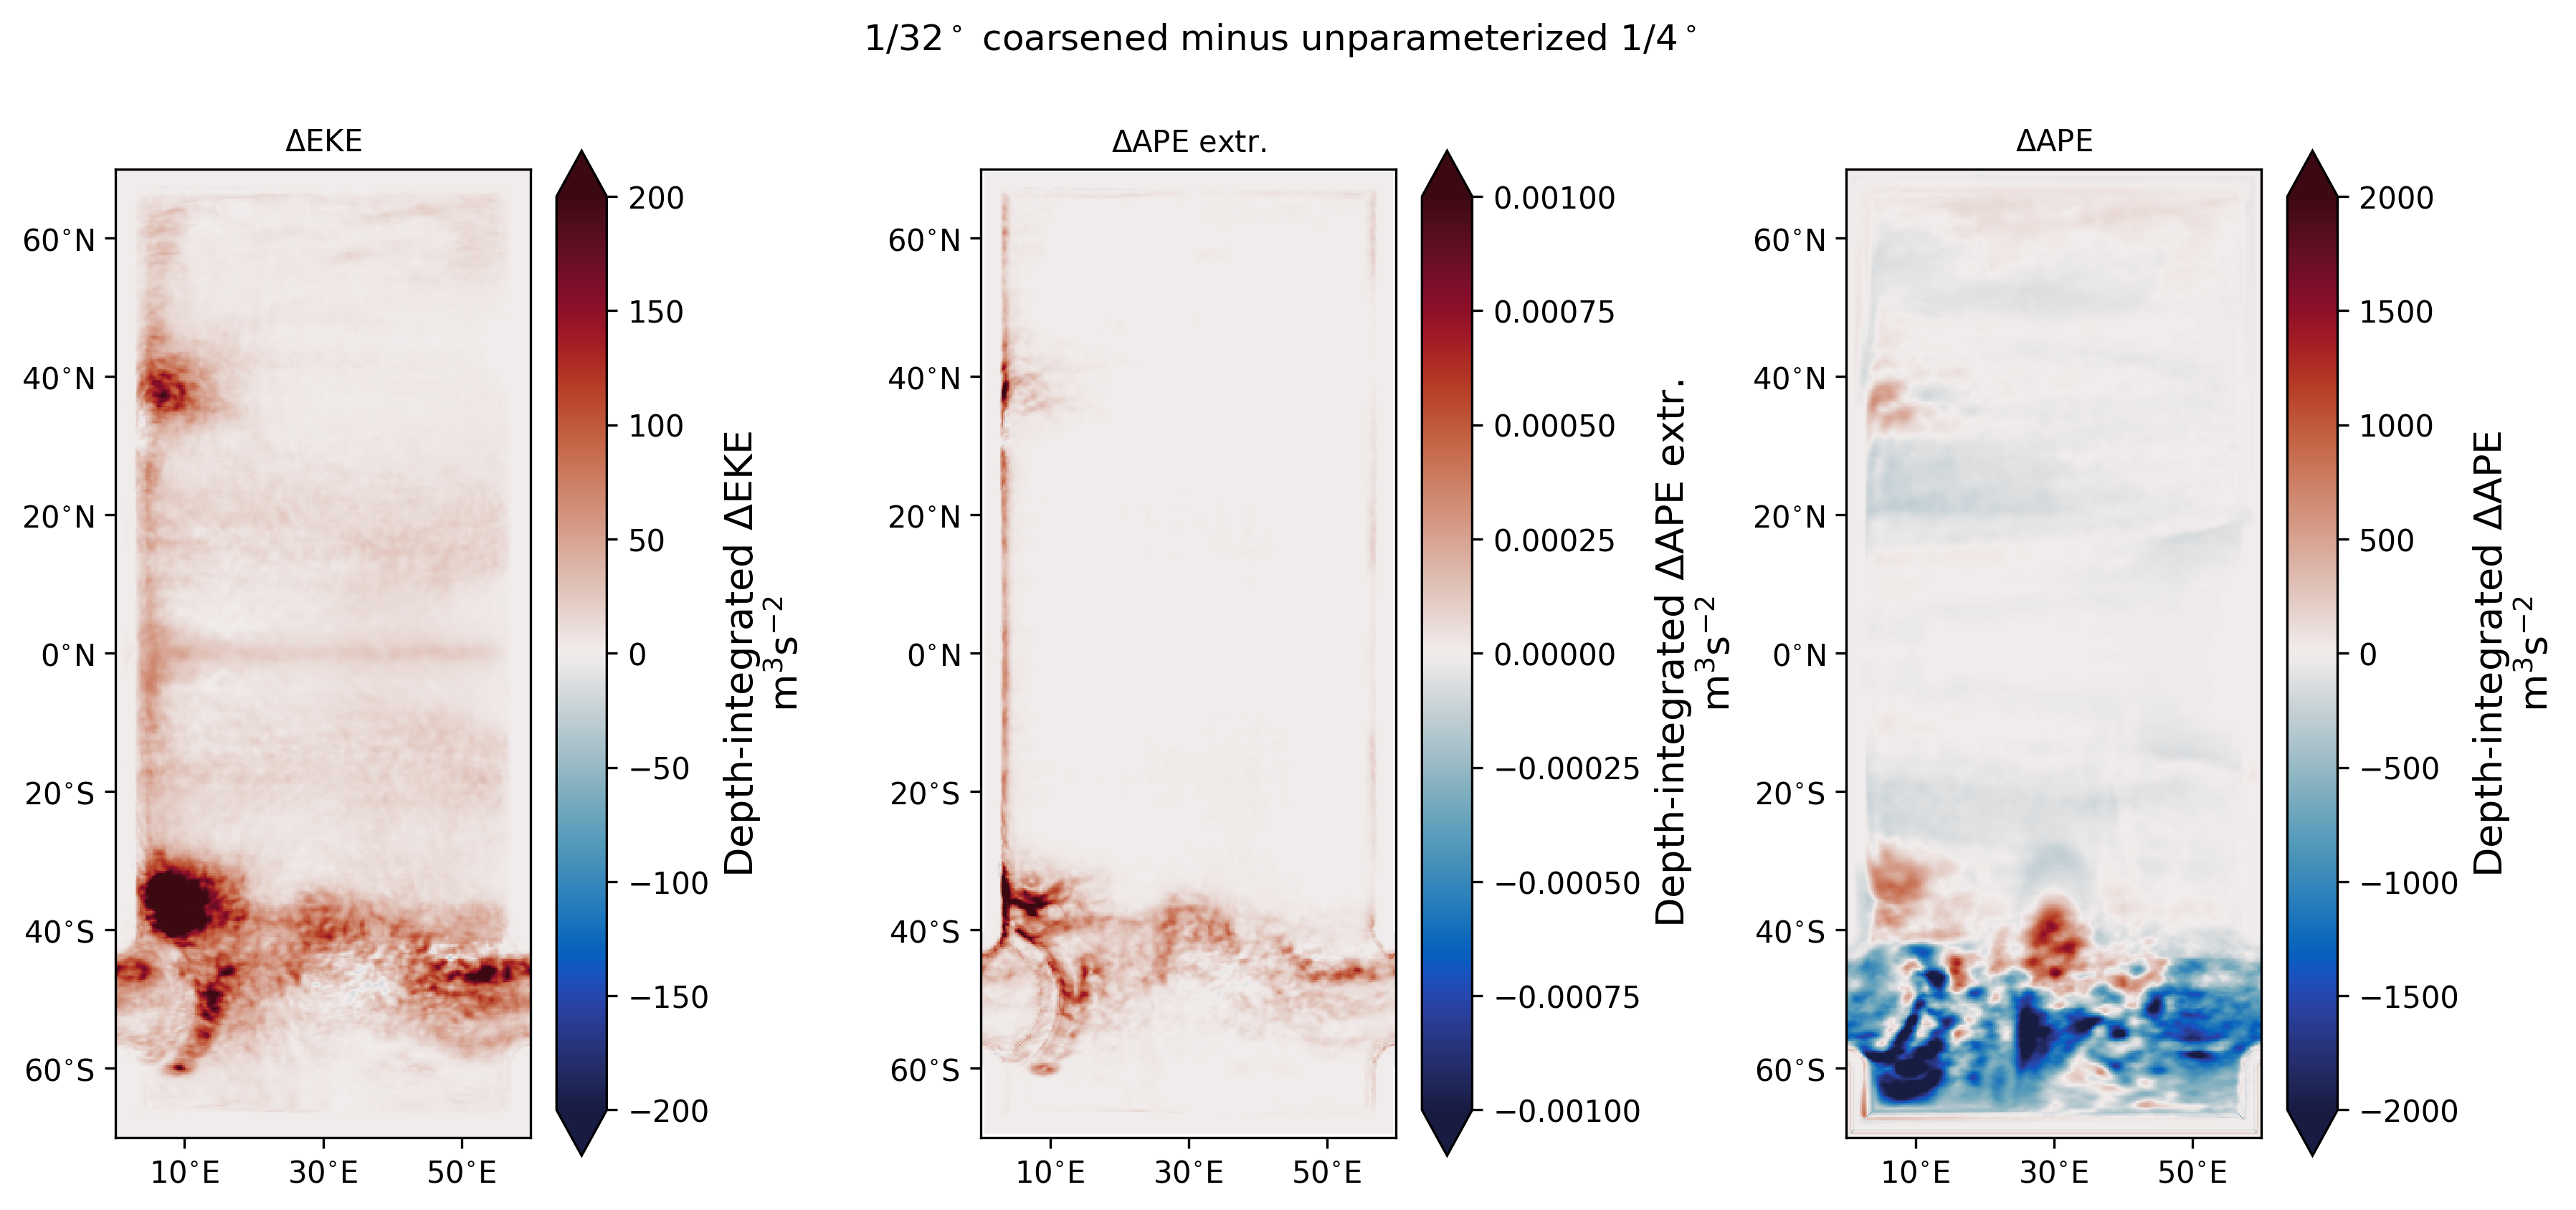

In [158]:
plt.figure(figsize=(12,7), dpi=300)
plt.subplot(1,3,1)
plot(energy_ref.EKE - energy_ctrl.EKE, vmin=-200, vmax=200, label='$\Delta$EKE', norm='linear', factor=1)
plt.subplot(1,3,2)
plot(dAPE_extraction, label='$\Delta$APE extr.', vmin=-0.001, vmax=0.001,norm='linear', factor=1)
plt.subplot(1,3,3)
plot(energy_ref.APE - energy_ctrl.APE, vmin=-2000, vmax=2000, label='$\Delta$APE', norm='linear', factor=1)

plt.suptitle('$1/32^\circ$ coarsened minus unparameterized $1/4^\circ$', y=0.9)
plt.tight_layout()

# Eulerian mean and eddy streamfunctions
Consider
$$
\partial_t h_k + \nabla (h_k \mathbf{u}_k) = 0
$$
We do not have sources and sinks of mass, and so the RHS is strictly zero. Apply Reynolds (time) averaging:
$$
 \nabla (\langle h_k \mathbf{u}_k \rangle_{t} ) = 0
$$
Thus, mean and eddy contributions compensate each other:
$$
\nabla (\langle h_k \rangle_t \langle \mathbf{u}_k \rangle_{t} + \langle h_k' \mathbf{u}_k' \rangle_t ) = 0
$$

Let's define the overturning streamfunction for mean and eddies as:
$$
\Psi_{mean} = \sum_{k=K}^{k} \int \langle h_k \rangle_t \langle v_k \rangle_t dx
$$
and
$$
\Psi_{eddy} = \sum_{k=K}^{k} \int \langle h_k' v_k' \rangle_t dx
$$
And
$$
\Psi_{residual} = \Psi_{mean} + \Psi_{eddy}
$$

These two stream-functions must be oppositely directed, because:
$$
0 = \int \nabla (\langle h_k \mathbf{u}_k \rangle_{t} ) dx = \partial_y \int \langle h_k v_k \rangle_{t} dx = 0
$$
Having no-mass flux boundary condition at the North, we have:
$$
\int \langle h_k v_k \rangle_{t} dx = 0
$$
and
$$
\int \langle h_k \rangle_t \langle v_k \rangle_t dx + \int \langle h_k' v_k' \rangle_t dx  = 0
$$

In [20]:
total_flux = (ref_longmean.vh).sum('xh').mean('time').compute() * 1e-6

In [21]:
mean_flux = (ref_longmean.v.mean('time')  * grid_ref.interp(ref_longmean.h.mean('time'), 'Y') * ref_static.dxCv).sum('xh').compute() * 1e-6

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [22]:
eddy_flux = total_flux - mean_flux

In [27]:
total_flux_lores = (R4_longmean.vh).sum('xh').mean('time').compute() * 1e-6

In [30]:
mean_flux_lores = (R4_longmean.v.mean('time')  * grid.interp(R4_longmean.h.mean('time'), 'Y') * lores_static.dxCv).sum('xh').compute() * 1e-6

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [31]:
eddy_flux_lores = total_flux_lores - mean_flux_lores

In [56]:
mean_flux_lores_true = (lores_longmean.v.mean('time')  * grid.interp(lores_longmean.h.mean('time'), 'Y') * lores_static.dxCv).sum('xh').compute() * 1e-6

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [57]:
mean_flux_ann = (ann_longmean.v.mean('time')  * grid.interp(ann_longmean.h.mean('time'), 'Y') * lores_static.dxCv).sum('xh').compute() * 1e-6

/ext3/miniconda3/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


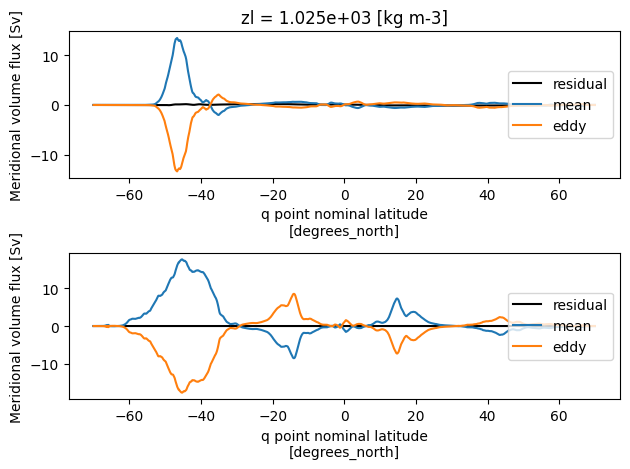

In [215]:
plt.subplot(2,1,1)
total_flux.isel(zl=5).plot(color='k', label='residual')
mean_flux.isel(zl=5).plot(label='mean')
eddy_flux.isel(zl=5).plot(label='eddy')
plt.ylabel('Meridional volume flux [Sv]')
plt.legend(loc='right')

plt.subplot(2,1,2)
total_flux.sum('zl').plot(color='k', label='residual')
mean_flux.sum('zl').plot(label='mean')
eddy_flux.sum('zl').plot(label='eddy')
plt.ylabel('Meridional volume flux [Sv]')
plt.legend(loc='right')
plt.tight_layout()

In [32]:
def compute_psi(thickness_flux):
    '''
    Flux is computed from bottom
    '''
    # Defined on zi with bottom but without surface
    psi = thickness_flux.cumsum('zl')
    # Set zero boundary condition
    psi = psi.pad({'zl':(1,0)}, constant_values=0).rename({'zl':'zi'})
    # I.e., integrate from bottom
    psi = psi - psi.isel(zi=-1)
    return psi.compute()

In [24]:
psi_mean = compute_psi(mean_flux)
psi_eddy = compute_psi(eddy_flux)

In [33]:
psi_mean_lores = compute_psi(mean_flux_lores)
psi_eddy_lores = compute_psi(eddy_flux_lores)

In [60]:
psi_mean_lores_true = compute_psi(mean_flux_lores_true)
psi_mean_ann = compute_psi(mean_flux_ann)

In [25]:
z = (ref_longmean.e.mean(['time','xh']).compute()).fillna(0.)

In [34]:
z_lores = (R4_longmean.e.mean(['time','xh']).compute()).fillna(0.)

Text(0.5, 1.2, '$1/32^\\circ$ simulation')

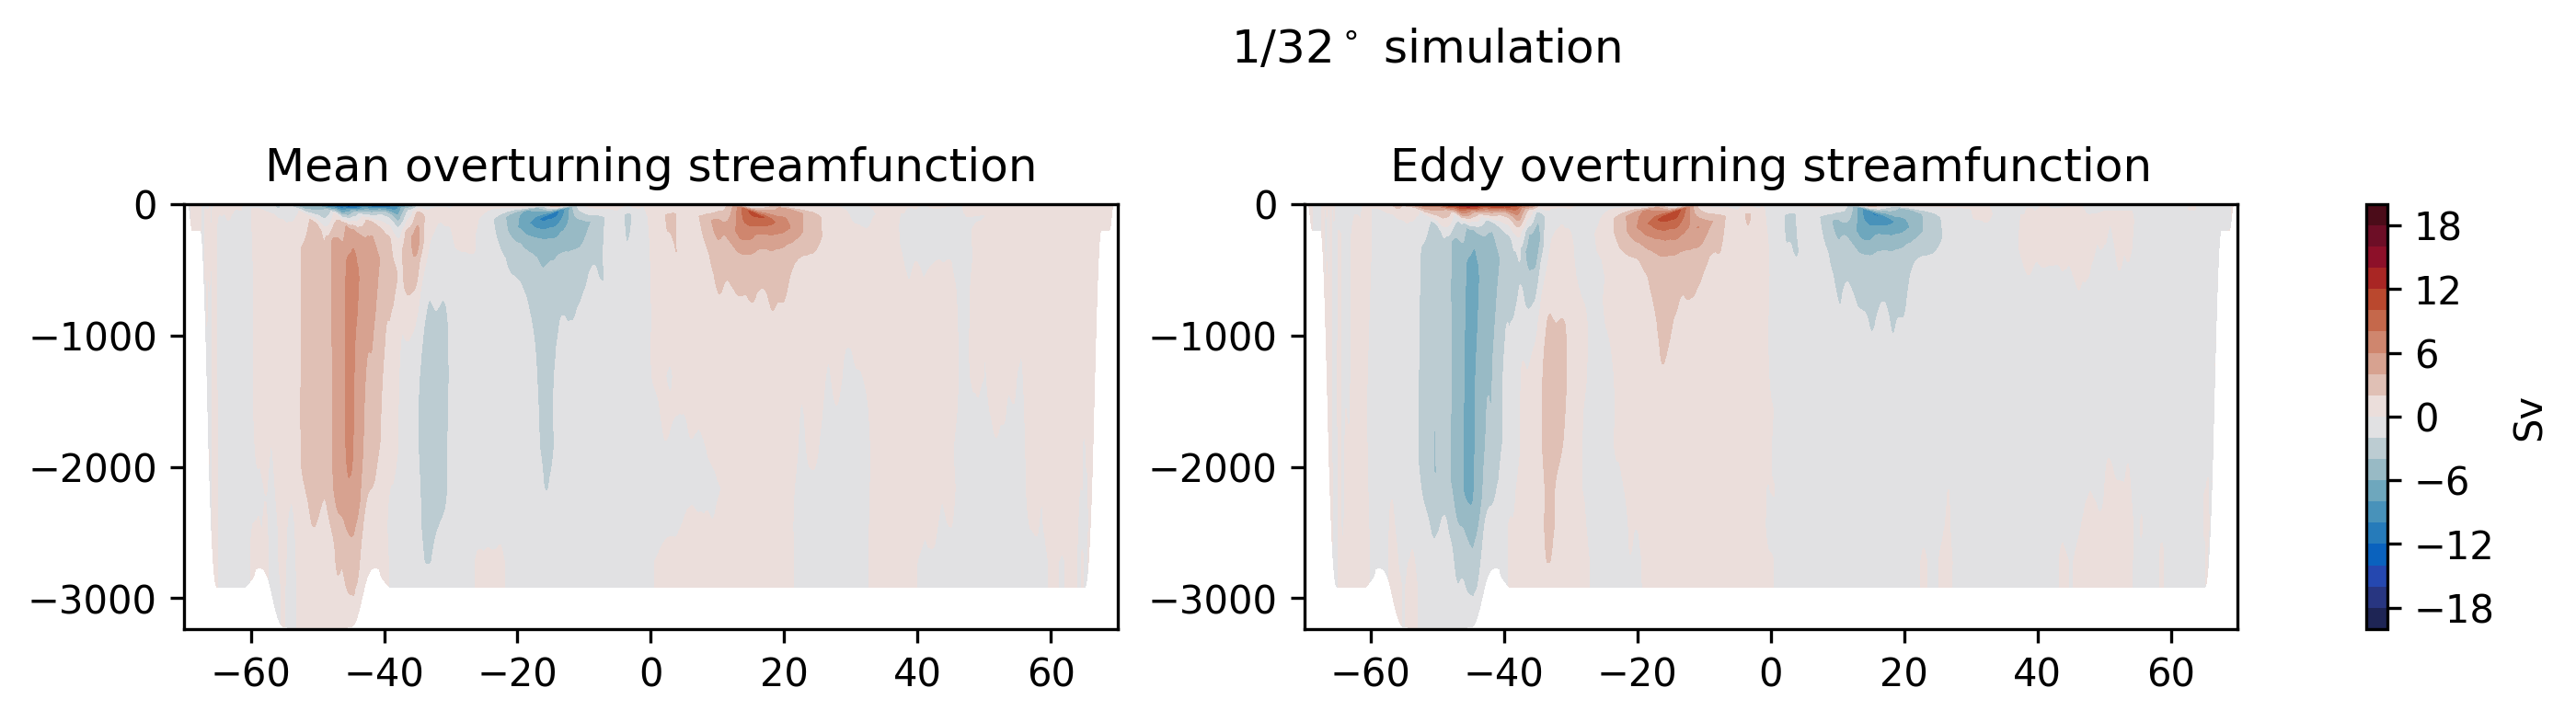

In [41]:
plt.figure(figsize=(12,2), dpi=300)
plt.subplot(1,2,1)
im = plt.contourf(np.tile(z.yh.data,(16,1)), z, psi_mean.interp(yq=z.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.title('Mean overturning streamfunction')

plt.subplot(1,2,2)
im = plt.contourf(np.tile(z.yh.data,(16,1)), z, psi_eddy.interp(yq=z.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.colorbar(im, ax=plt.gcf().axes, label='Sv')
plt.title('Eddy overturning streamfunction')
plt.suptitle('$1/32^\circ$ simulation',y=1.2)

Text(0.5, 1.2, '$1/4^\\circ$ simulation')

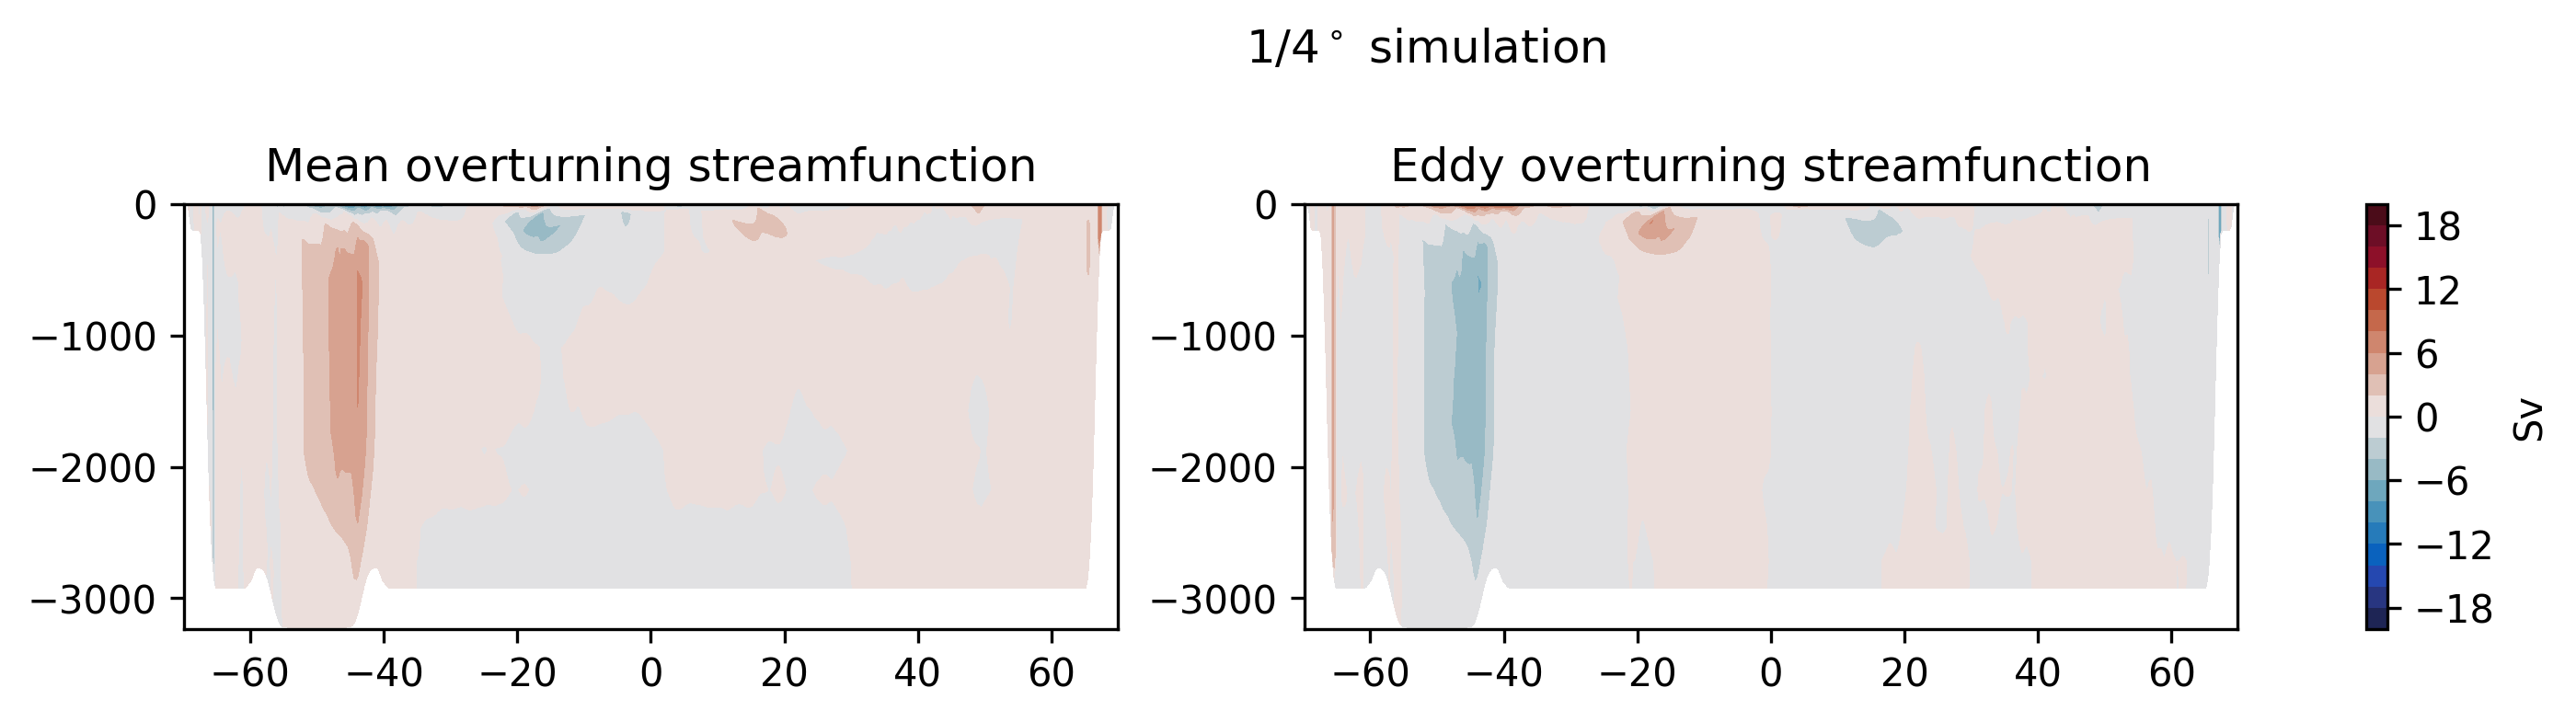

In [43]:
plt.figure(figsize=(12,2), dpi=300)
plt.subplot(1,2,1)
im = plt.contourf(np.tile(z_lores.yh.data,(16,1)), z_lores, psi_mean_lores.interp(yq=z_lores.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.title('Mean overturning streamfunction')

plt.subplot(1,2,2)
im = plt.contourf(np.tile(z_lores.yh.data,(16,1)), z_lores, psi_eddy_lores.interp(yq=z_lores.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.colorbar(im, ax=plt.gcf().axes, label='Sv')
plt.title('Eddy overturning streamfunction')
plt.suptitle('$1/4^\circ$ simulation',y=1.2)

Text(0.5, 1.2, '$1/4^\\circ$ simulation')

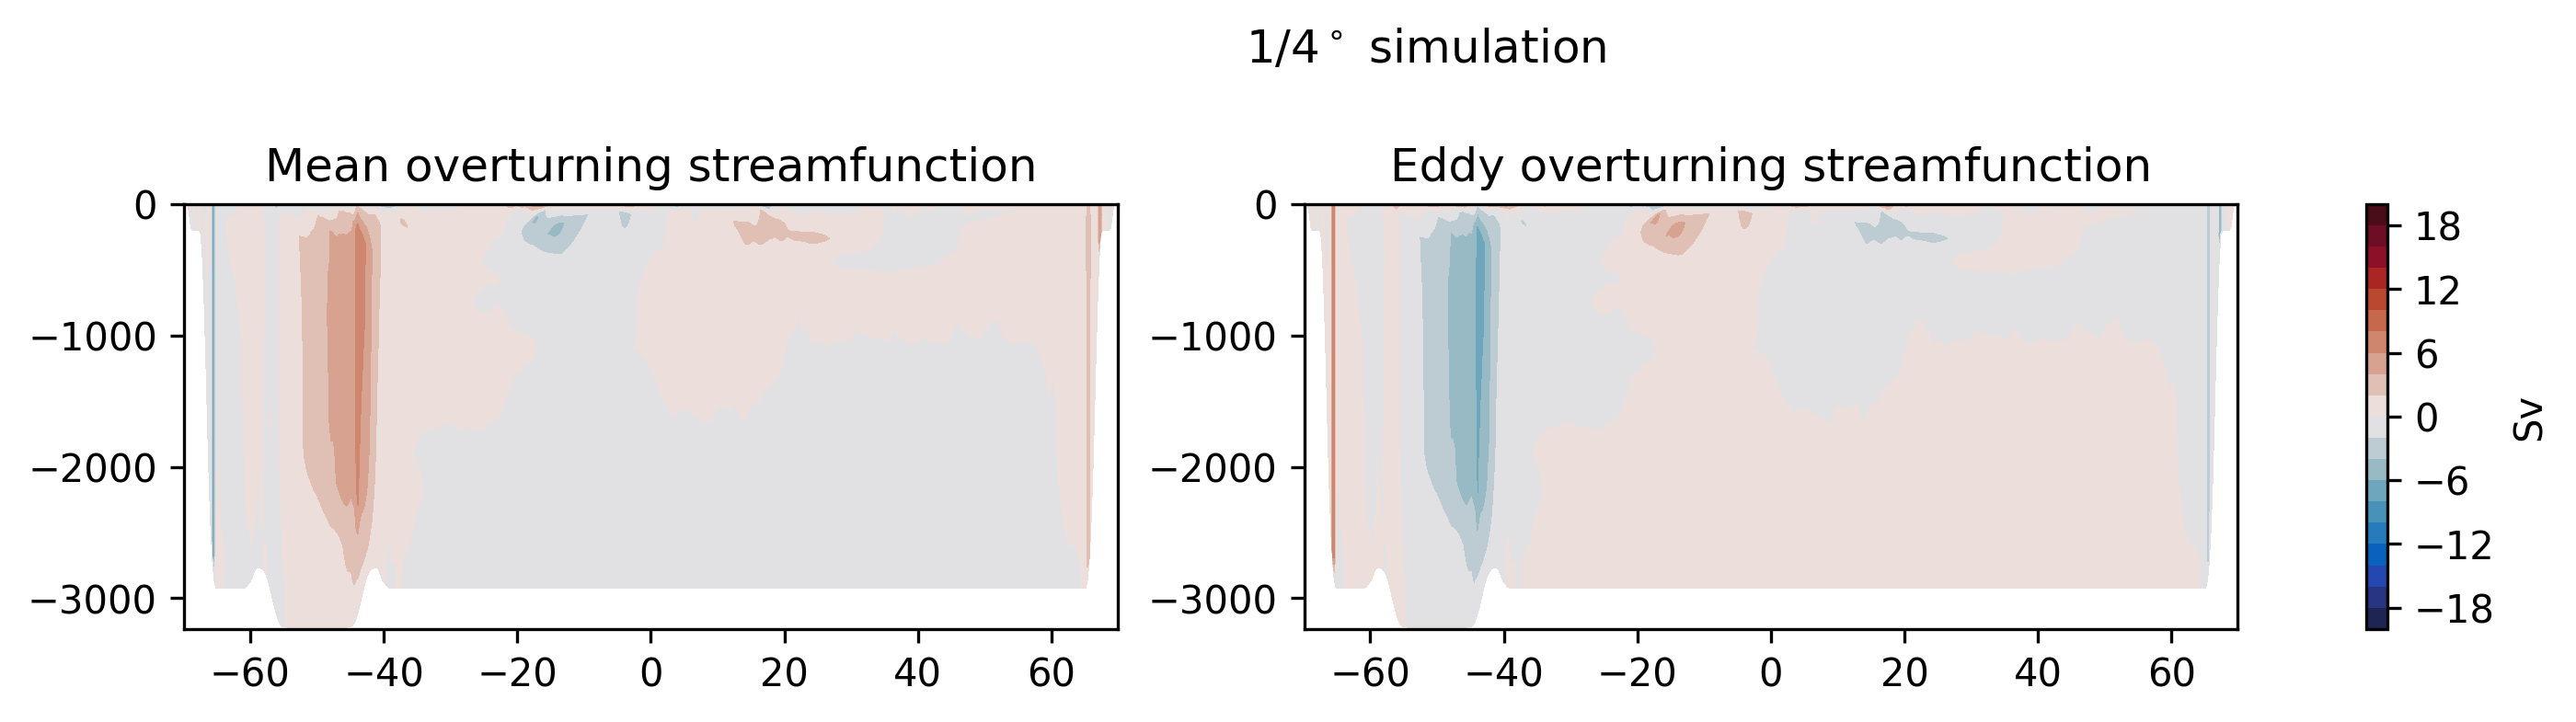

In [59]:
plt.figure(figsize=(12,2), dpi=300)
plt.subplot(1,2,1)
im = plt.contourf(np.tile(z_lores.yh.data,(16,1)), z_lores, psi_mean_lores_true.interp(yq=z_lores.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.title('Mean overturning streamfunction')

plt.subplot(1,2,2)
im = plt.contourf(np.tile(z_lores.yh.data,(16,1)), z_lores, -psi_mean_lores_true.interp(yq=z_lores.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.colorbar(im, ax=plt.gcf().axes, label='Sv')
plt.title('Eddy overturning streamfunction')
plt.suptitle('$1/4^\circ$ simulation',y=1.2)

Text(0.5, 1.2, '$1/4^\\circ$ simulation')

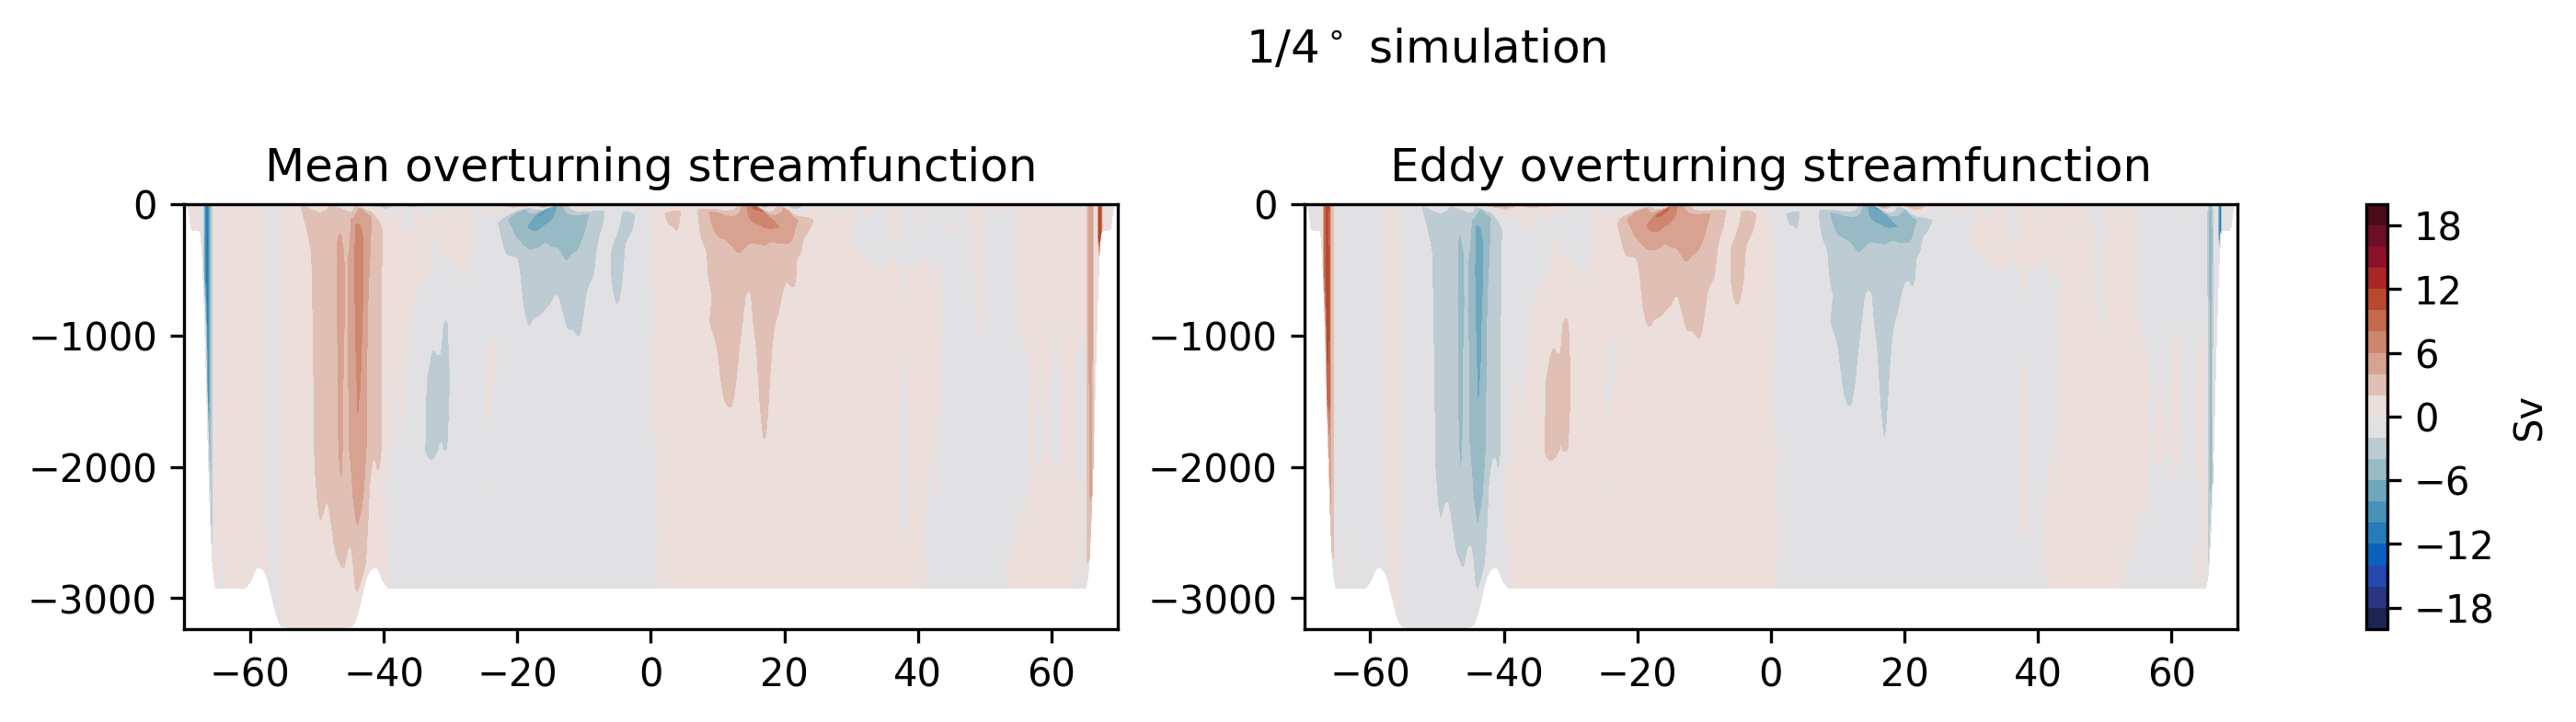

In [61]:
plt.figure(figsize=(12,2), dpi=300)
plt.subplot(1,2,1)
im = plt.contourf(np.tile(z_lores.yh.data,(16,1)), z_lores, psi_mean_ann.interp(yq=z_lores.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.title('Mean overturning streamfunction')

plt.subplot(1,2,2)
im = plt.contourf(np.tile(z_lores.yh.data,(16,1)), z_lores, -psi_mean_ann.interp(yq=z_lores.yh), cmap=cmocean.cm.balance, levels=np.arange(-20,22,2))
plt.colorbar(im, ax=plt.gcf().axes, label='Sv')
plt.title('Eddy overturning streamfunction')
plt.suptitle('$1/4^\circ$ simulation',y=1.2)

# Are there succesful runs? 

Text(0.5, 0.98, 'NW2 at 1/2-degree resolution')

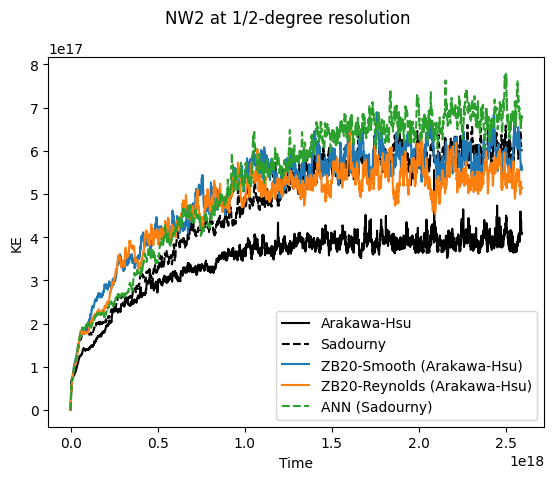

In [173]:
xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-long/bare/output/ocean.stats.nc').KE.sum('Layer').plot(color='k', label='Arakawa-Hsu')
xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-long/bare-Sadourny/output/ocean.stats.nc').KE.sum('Layer').plot(color='k', ls='--', label='Sadourny')

xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-long/Smooth/output/ocean.stats.nc').KE.sum('Layer').plot(label='ZB20-Smooth (Arakawa-Hsu)')
xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-long/Reynolds/output/ocean.stats.nc').KE.sum('Layer').plot(label='ZB20-Reynolds (Arakawa-Hsu)')

xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R2-ANN/May22/sadourny/output/ocean.stats.nc').KE.sum('Layer').plot(label='ANN (Sadourny)', ls='--')

plt.legend()

plt.suptitle('NW2 at 1/2-degree resolution')
#plt.axhline(y=1.84e+18, color='k')